In [1]:
from os import chdir
chdir('/Users/lananhnguyen/Desktop/thesis/thesis_code')
from packages.load import *

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

import statsmodels.tsa.stattools as ts
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error, mean_squared_error



## Load and clean data:
Since we have covid period and it can mess with our data, we'll do:
split out-of-sampple forcasting into 3 periods: precovid, in covid and after covid.

Data length: 331 rows from 1996-01-01 00:00:00 to 2023-07-01 00:00:00
0           hicp_all
date                
1996-01-01      75.1
1996-02-01      75.6
1996-03-01      75.7
1996-04-01      75.6
1996-05-01      75.7


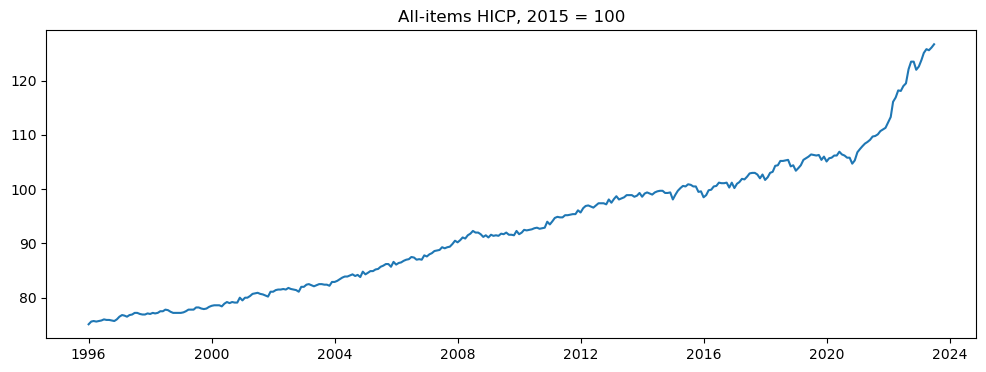

In [2]:
headline = load_excel('data/hicp_all.xlsx', 'hicp_all')
data_viz(headline, title= 'All-items HICP, 2015 = 100')

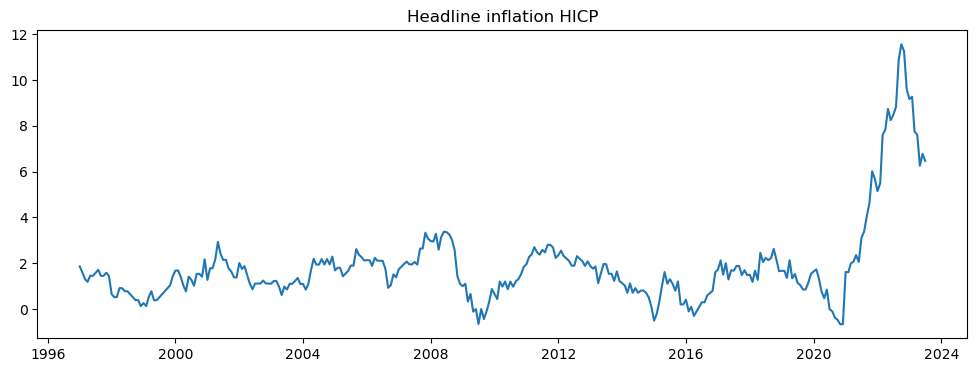

In [3]:
head_inf = transform_yoy_rate(headline)
data_viz(head_inf, title= 'Headline inflation HICP')
head_inf.to_csv('data/preprocessed/head_inflation.csv')

### test for autocorr and model:

In [9]:
autocorr_values = head_inf.autocorr()
print("Autocorrelation:", autocorr_values) #large autocorr -> can be AR model

Autocorrelation: 0.9721133972549411


In [10]:
dftest(head_inf)

Test Statistic        -3.198781
p-value                0.020055
Lags Used             14.000000
Observations Used    304.000000
dtype: float64
Time series is stationary!


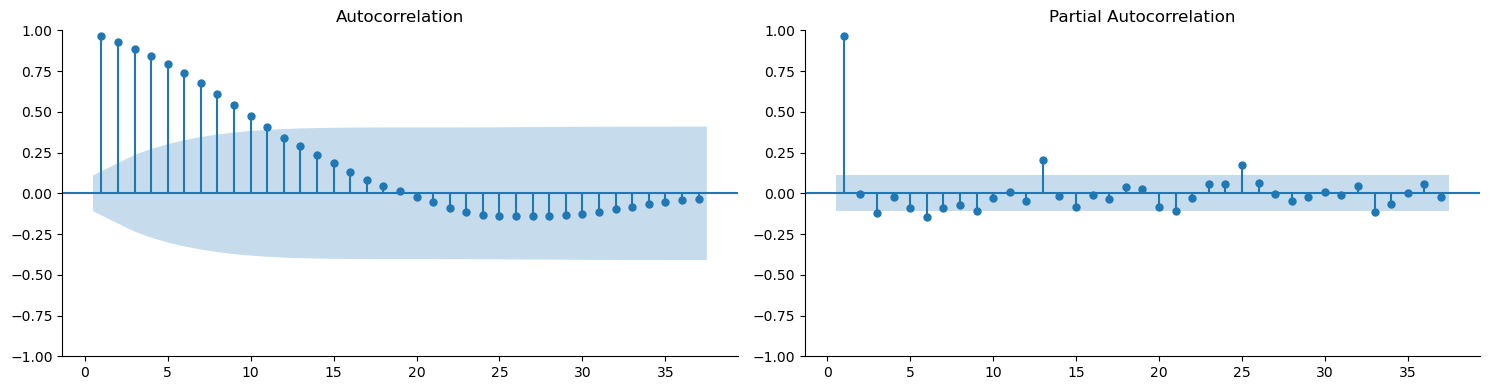

In [11]:
plots(head_inf, lags = 37)

ACF is initially large, then decays gradually to zero, then switch to be negative.
p = 1, 13, 25, 37,... have large PACF -> annual seasonality.

Also I'll split the data so to have out-of-sample forecast, and there's covid time, so I will split like:
training data: 1/1998-12/2015
test 1: 1/2016 - 12/2019 - precovid
test 2: 2020-2021 - during covid
test 3: 2022 - after covid and ukrain war and energy spike

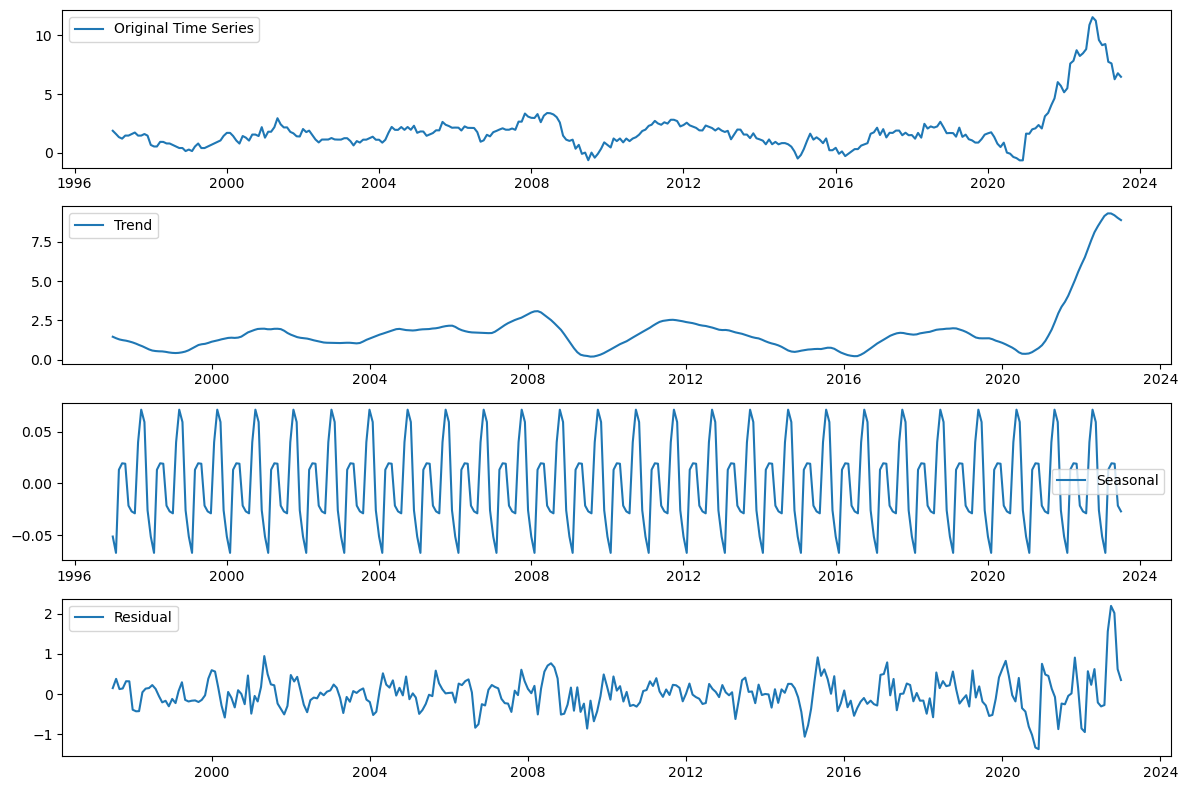

In [22]:
# Apply seasonal decomposition
result = seasonal_decompose(head_inf, model='additive')


# Plot the original time series
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(head_inf, label='Original Time Series')
plt.legend()

# Plot the trend component
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()

# Plot the seasonal component
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

# Plot the residual component
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


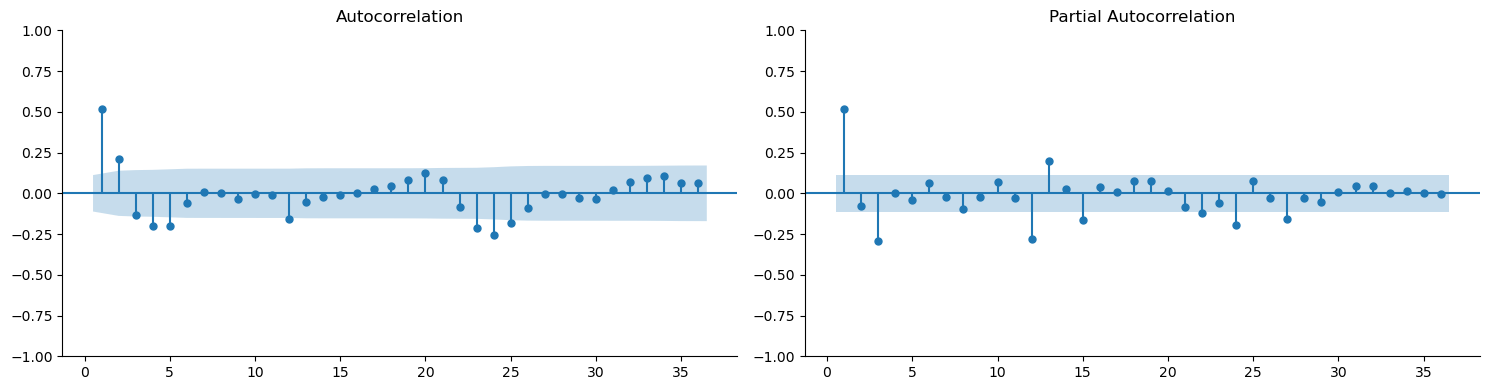

In [23]:
plots(result.resid[result.resid.notna()], lags=36);

/Users/lananhnguyen/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


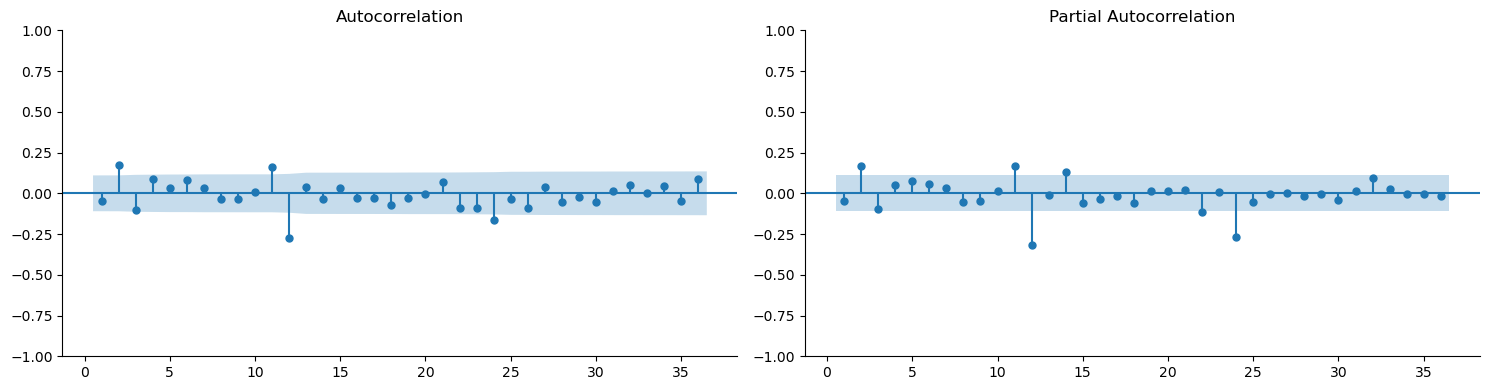

In [51]:
head_inf_year_diff = head_inf.diff(1)
plots(head_inf_year_diff.dropna(), lags=36)

In [11]:
head_inf_train = head_inf[head_inf.index <= '2015-12-31']
head_inf_test = head_inf[head_inf.index > '2015-12-31']

## Model:

Try with the most basic model ARMA(1, 0, 0) then try with more complicated model.????

### Model 1:
Most basic model: AR(1), but have to differencing 1, because 

In [96]:
order1 = (1, 1, 0)
seasonal_order1 = None

base_1 = SARIMAX(head_inf_train, 
                order=order1,
                seasonal_order=seasonal_order1,
                trend ='n').fit()
base_1.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20034D-01    |proj g|=  4.38112D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      6      1     0     0   1.867D-04   3.200D-01
  F =  0.32003360394555896     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               yoy_rate   No. Observations:                  228
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -72.968
Date:                Tue, 13 Feb 2024   AIC                            149.935
Time:                        18:07:39   BIC                            156.785
Sample:                    01-01-1997   HQIC                           152.699
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1441      0.059     -2.424      0.015      -0.261      -0.028
sigma2         0.1113      0.009     12.182      0.000       0.093       0.129
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 4.91
Prob(Q):                              0.82   Prob(JB):                         0.09
Heteroskedasticity (H):               1.20   Skew:                            -0.14
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

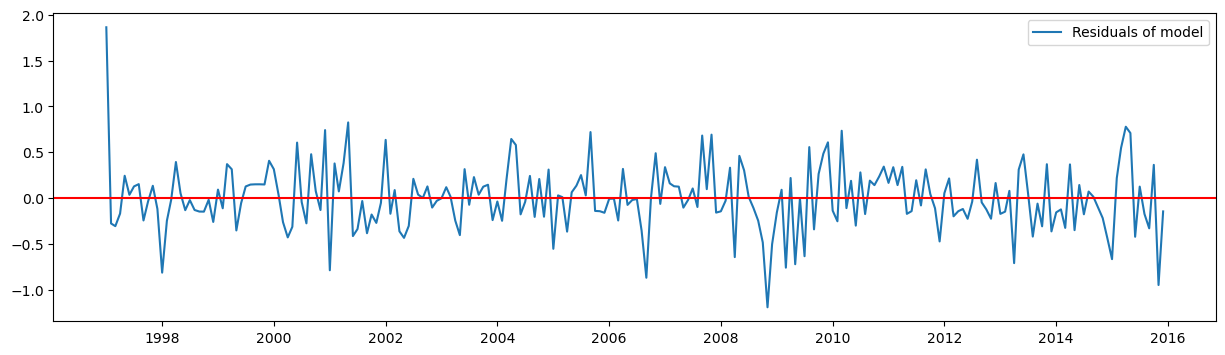

In [97]:
plt.figure(figsize=(15, 4))
plt.plot(base_1.resid, label = 'Residuals of model')
plt.axhline(base_1.resid.mean(), color = 'r')
plt.legend()
plt.show()

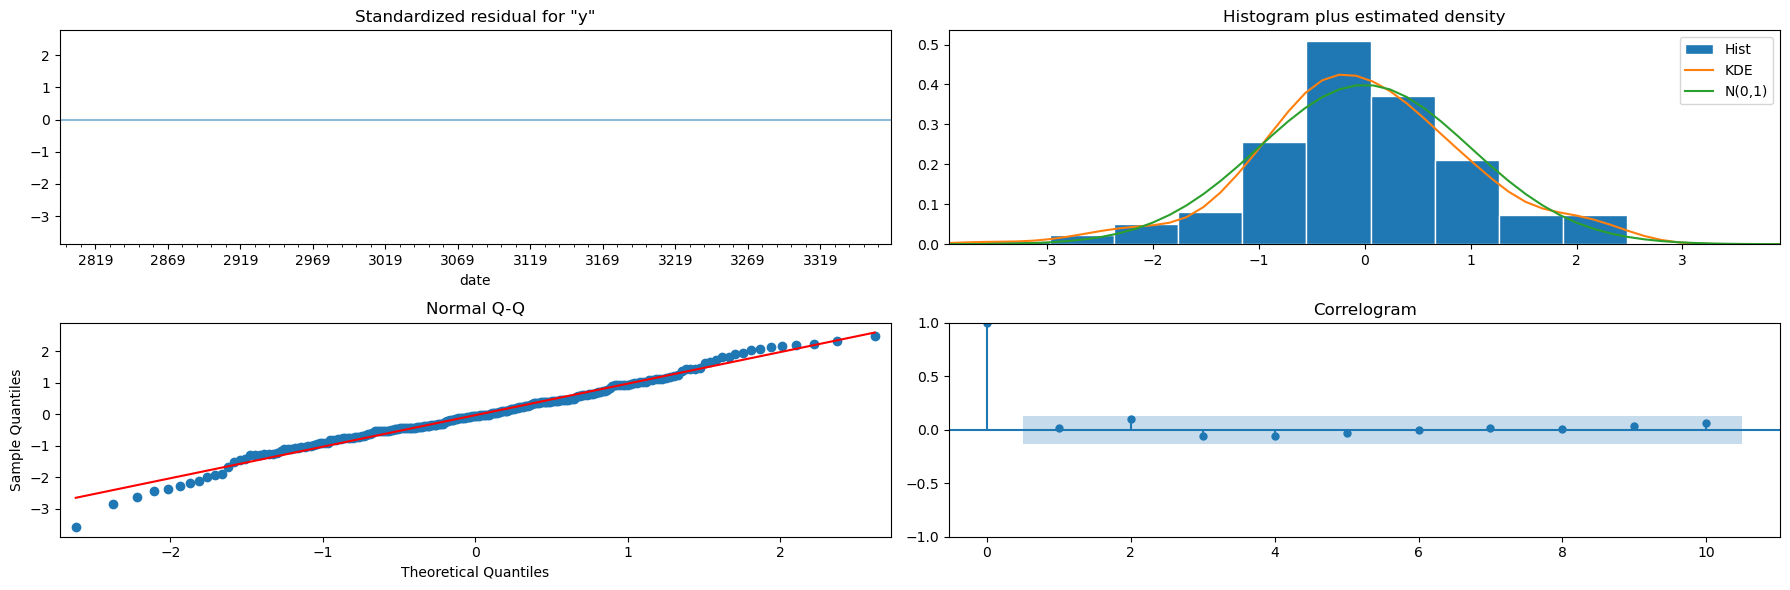

In [98]:
base_1.plot_diagnostics(figsize= (18, 6))
plt.tight_layout()
plt.show()

In [94]:
horizons = [1, 2, 3] # horizon

# function for forecasting:

def forecast_results(order, seasonal_order, horizons = horizons, N = len(head_inf_train), T = len(head_inf_test)):
    """
    Create forecast results after doing SARIMAX recursive forecast, using for baseline models
    Args:
    - order: trained order 
    - seasonal_order: seasonal order
    - horizon: forecast horizon
    - N: length of training period
    - T: length of test period
    """
    forecast_df = pd.DataFrame()
    
# Iterate through the time series data
    for h in horizons:
        forecasts = []    
        for i in range(1, T +1):
        
            # Define the expanding window training set
            train_data = head_inf[:N+i-h]
            print(f'Horizon {h}, step {i}')

            # Create and fit the SARIMAX model
            model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, trend='n')
            model_fit = model.fit(disp = False)
        
            # Forecast h step ahead
            pred = model_fit.forecast(steps =h)
            print('Prediction: ', pred)
            forecasts.append(pred[-1])
        # Assign the forecasted values to a new column in the DataFrame
        forecast_df[f'Horizon_{h}'] = forecasts
        
    forecast_df['Real_obs'] = head_inf_test.values
    forecast_df.set_index(head_inf_test.index, inplace = True)

    for h in horizons:
        forecast_df[f'Error_horizon_{h}'] = forecast_df['Real_obs'] - forecast_df[f'Horizon_{h}']
    
    return forecast_df

In [99]:
forecast_df1 = forecast_results(order=order1, seasonal_order= seasonal_order1)
forecast_df1

Horizon 1, step 1
Prediction:  2016-01-01    0.201236
Freq: MS, dtype: float64
Horizon 1, step 2
Prediction:  2016-02-01    0.377993
Freq: MS, dtype: float64
Horizon 1, step 3
Prediction:  2016-03-01   -0.025772
Freq: MS, dtype: float64
Horizon 1, step 4
Prediction:  2016-04-01    0.070035
Freq: MS, dtype: float64
Horizon 1, step 5
Prediction:  2016-05-01   -0.238173
Freq: MS, dtype: float64
Horizon 1, step 6
Prediction:  2016-06-01   -0.130462
Freq: MS, dtype: float64
Horizon 1, step 7
Prediction:  2016-07-01    0.068961
Freq: MS, dtype: float64
Horizon 1, step 8
Prediction:  2016-08-01    0.267289
Freq: MS, dtype: float64
Horizon 1, step 9
Prediction:  2016-09-01    0.297574
Freq: MS, dtype: float64
Horizon 1, step 10
Prediction:  2016-10-01    0.551627
Freq: MS, dtype: float64
Horizon 1, step 11
Prediction:  2016-11-01    0.681614
Freq: MS, dtype: float64
Horizon 1, step 12
Prediction:  2016-12-01    0.787967
Freq: MS, dtype: float64
Horizon 1, step 13
Prediction:  2017-01-01    1.4

,Horizon_1,Horizon_2,Horizon_3,Real_obs,Error_horizon_1,Error_horizon_2,Error_horizon_3
date,,,,,,,
2016-01-01,0.201236,0.329779,1.160298,0.407747,0.206511,0.077968,-0.752551
2016-02-01,0.377993,0.201232,0.333175,-0.101010,-0.479003,-0.302242,-0.434186
2016-03-01,-0.025772,0.382279,0.201233,0.100301,0.126072,-0.281978,-0.100932
2016-04-01,0.070035,-0.036898,0.381662,-0.299401,-0.369436,-0.262503,-0.681063
2016-05-01,-0.238173,0.074585,-0.035253,-0.099404,0.138769,-0.173989,-0.064151
...,...,...,...,...,...,...,...
2023-03-01,9.263782,9.187844,9.695921,7.751938,-1.511844,-1.435906,-1.943983
2023-04-01,7.813556,9.263921,9.187867,7.613345,-0.200211,-1.650577,-1.574522
2023-05-01,7.618287,7.811051,9.263916,6.260575,-1.357712,-1.550475,-3.003341


In [100]:
# Metric df:

metrics_df = pd.DataFrame(columns=['base1_rmse', 'base1_mae'], index=horizons)

for h in horizons:
    metrics_df.loc[h, 'base1_rmse'] = np.sqrt(mean_squared_error(forecast_df1['Real_obs'], forecast_df1[f'Horizon_{h}']))
    metrics_df.loc[h, 'base1_mae'] = mean_absolute_error(forecast_df1['Real_obs'], forecast_df1[f'Horizon_{h}'])

print(metrics_df)


  base1_rmse base1_mae
1   0.643753  0.448755
2   0.926208   0.65364
3   1.204485  0.894005


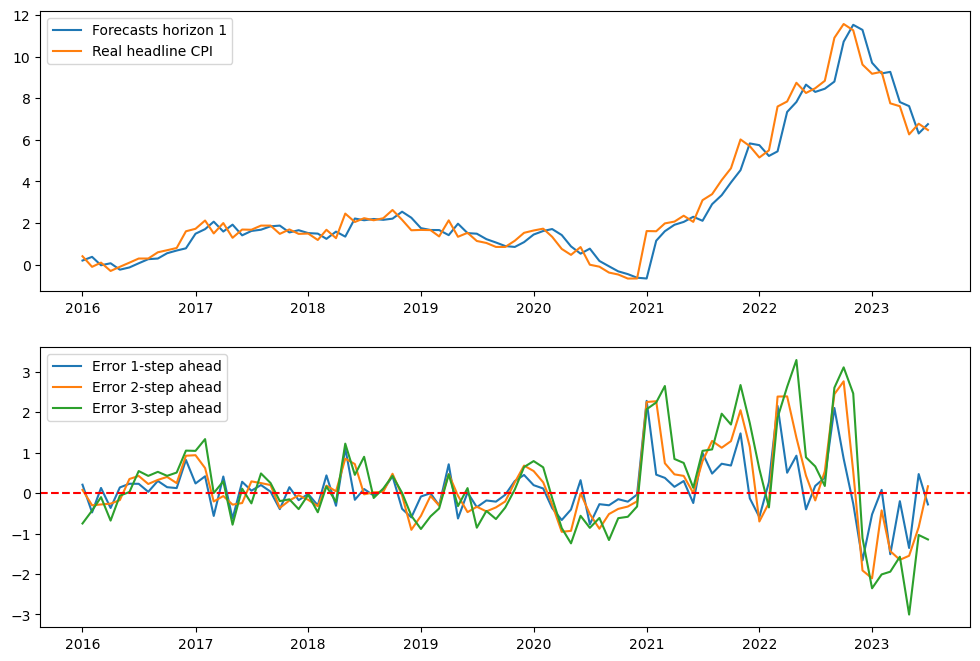

In [101]:
plt.figure(figsize = (12, 8))
plt.subplot(211)
plt.plot(forecast_df1.index, forecast_df1['Horizon_1'], label = 'Forecasts horizon 1')
plt.plot(forecast_df1['Real_obs'], label = 'Real headline CPI')
plt.legend()

plt.subplot(212)
plt.plot(forecast_df1['Error_horizon_1'], label = 'Error 1-step ahead')
plt.plot(forecast_df1['Error_horizon_2'], label = 'Error 2-step ahead')
plt.plot(forecast_df1['Error_horizon_3'], label = 'Error 3-step ahead')

plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.legend()
plt.show()


### Model 2:
Optimise the training data set

In [65]:
stepwise_model = pm.auto_arima(head_inf_train, 
                            start_p=2, start_q=0,
                           max_p=12, max_q=12, m=12,
                           start_P=1, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                            information_criterion='bic') 
print(stepwise_model.bic())
print(stepwise_model.summary())

Performing stepwise search to minimize bic
 ARIMA(2,0,0)(1,1,1)[12] intercept   : BIC=inf, Time=1.23 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : BIC=653.292, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : BIC=290.267, Time=0.36 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : BIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : BIC=648.316, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : BIC=355.334, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : BIC=228.659, Time=0.89 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : BIC=inf, Time=2.20 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : BIC=inf, Time=0.85 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : BIC=595.736, Time=0.39 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : BIC=230.600, Time=1.29 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : BIC=231.492, Time=1.36 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : BIC=451.061, Time=0.41 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : BIC=233.453, Time=1.57 sec
 ARIMA(1,0,0)(2,1,0)[12]             : BIC=223.42

- The estimated standard deviation of the residuals (errors) is 0.1397. -> not 0
- Ljung-Box (Q): A test for autocorrelation of residuals. A value of 2.75 is observed, and a low p-value (0.10) suggests that there might be significant autocorrelation.
- Jarque-Bera (JB): A test for normality of residuals. The JB statistic is 1.27, and the p-value is 0.53, indicating that normality is not significantly violated.
- Heteroskedasticity (H): A test for constant variance of residuals. The H statistic is 1.23, and the p-value is 0.38, suggesting that there is no significant heteroskedasticity.

Skewness and Kurtosis:
- Skewness is approximately -0.02, indicating a slight left skewness.
- Kurtosis is 3.37, suggesting a distribution with moderate peakedness.


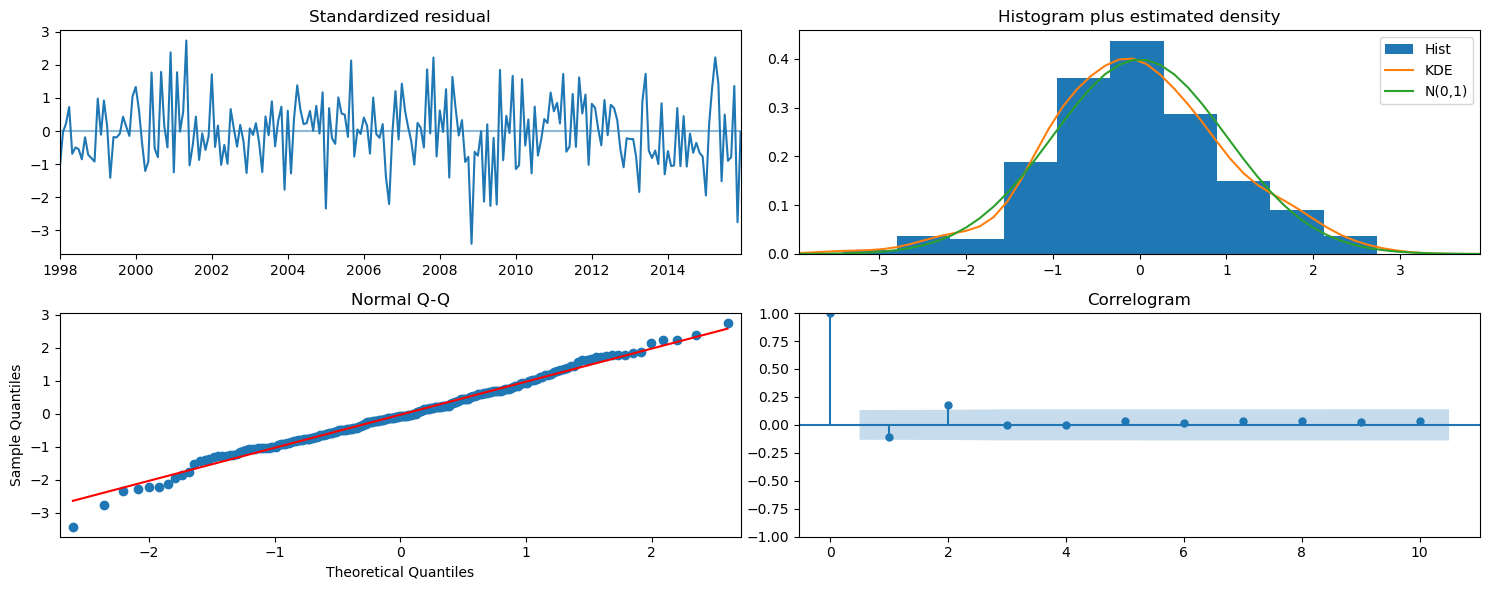

In [66]:
stepwise_model.plot_diagnostics(figsize= (15, 6))
plt.tight_layout()
plt.show()

In [103]:
order2 = stepwise_model.order
seasonal_order2 = stepwise_model.seasonal_order
print('order: ',order2)
print('seasonal order: ',seasonal_order2)

order:  (1, 0, 0)
seasonal order:  (2, 1, 0, 12)


In [104]:

sar = SARIMAX(head_inf_train, 
                order=order2,
                seasonal_order=seasonal_order2,
                trend ='n').fit()
sar.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.00171D-01    |proj g|=  6.03343D-01

At iterate    5    f=  4.53861D-01    |proj g|=  4.05000D-02


 This problem is unconstrained.



At iterate   10    f=  4.42960D-01    |proj g|=  8.57747D-03

At iterate   15    f=  4.42817D-01    |proj g|=  5.14621D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   6.935D-06   4.428D-01
  F =  0.44281718911592877     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           yoy_rate   No. Observations:                  228
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -100.962
Date:                            Tue, 13 Feb 2024   AIC                            209.925
Time:                                    18:12:10   BIC                            223.426
Sample:                                01-01-1997   HQIC                           215.379
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9309      0.024     38.708      0.000       0.884       0.978
ar.S.L12      -0.8657      0.056    -15.328      0.000      -0.976      -0.755
ar.S.L24      -0.5391      0.065     -8.355      0.000      -0.666      -0.413
sigma2         0.1397      0.013     10.890      0.000       0.115       0.165
===================================================================================
Ljung-Box (L1) (Q):                   2.75   Jarque-Bera (JB):                 1.27
Prob(Q):                              0.10   Prob(JB):                         0.53
Heteroskedasticity (H):               1.23   Skew:                            -0.02
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/lananhnguyen/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


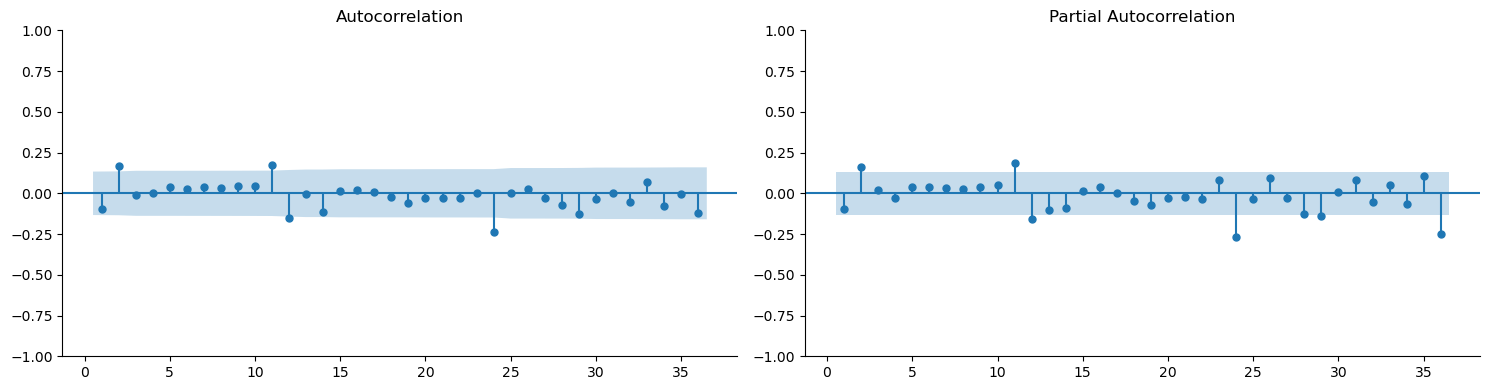

In [105]:
#plot the residuals

plots(sar.resid[sar.loglikelihood_burn:], lags=36);

Residuals are not white noise and still autocorrelated.

Now let's do out-of-sample forecast and calculate RMSE. 

## Forecast:
### Recursive Approach:
We apply the optimised model but adding more data recursively.

In [106]:

forecast_df2 = forecast_results(order=order2, seasonal_order= seasonal_order2)
forecast_df2

Horizon 1, step 1
Prediction:  2016-01-01    0.072791
Freq: MS, dtype: float64
Horizon 1, step 2
Prediction:  2016-02-01    0.41172
Freq: MS, dtype: float64
Horizon 1, step 3
Prediction:  2016-03-01    0.005707
Freq: MS, dtype: float64
Horizon 1, step 4
Prediction:  2016-04-01    0.014424
Freq: MS, dtype: float64
Horizon 1, step 5
Prediction:  2016-05-01   -0.036565
Freq: MS, dtype: float64
Horizon 1, step 6
Prediction:  2016-06-01    0.228816
Freq: MS, dtype: float64
Horizon 1, step 7
Prediction:  2016-07-01    0.144667
Freq: MS, dtype: float64
Horizon 1, step 8
Prediction:  2016-08-01    0.153543
Freq: MS, dtype: float64
Horizon 1, step 9
Prediction:  2016-09-01    0.325119
Freq: MS, dtype: float64
Horizon 1, step 10
Prediction:  2016-10-01    0.485528
Freq: MS, dtype: float64
Horizon 1, step 11
Prediction:  2016-11-01    0.758167
Freq: MS, dtype: float64
Horizon 1, step 12
Prediction:  2016-12-01    0.458614
Freq: MS, dtype: float64
Horizon 1, step 13
Prediction:  2017-01-01    1.32

,Horizon_1,Horizon_2,Horizon_3,Real_obs,Error_horizon_1,Error_horizon_2,Error_horizon_3
date,,,,,,,
2016-01-01,0.072791,0.082843,0.989463,0.407747,0.334957,0.324905,-0.581716
2016-02-01,0.411720,0.099485,0.109006,-0.101010,-0.512730,-0.200495,-0.210016
2016-03-01,0.005707,0.487820,0.197738,0.100301,0.094594,-0.387519,-0.097437
2016-04-01,0.014424,-0.074606,0.379617,-0.299401,-0.313825,-0.224795,-0.679018
2016-05-01,-0.036565,0.258348,0.173327,-0.099404,-0.062838,-0.357752,-0.272730
...,...,...,...,...,...,...,...
2023-03-01,9.448154,9.345467,10.431225,7.751938,-1.696216,-1.593529,-2.679287
2023-04-01,7.371444,9.108518,9.004342,7.613345,0.241901,-1.495173,-1.390997
2023-05-01,7.553113,7.309832,9.101679,6.260575,-1.292538,-1.049257,-2.841103


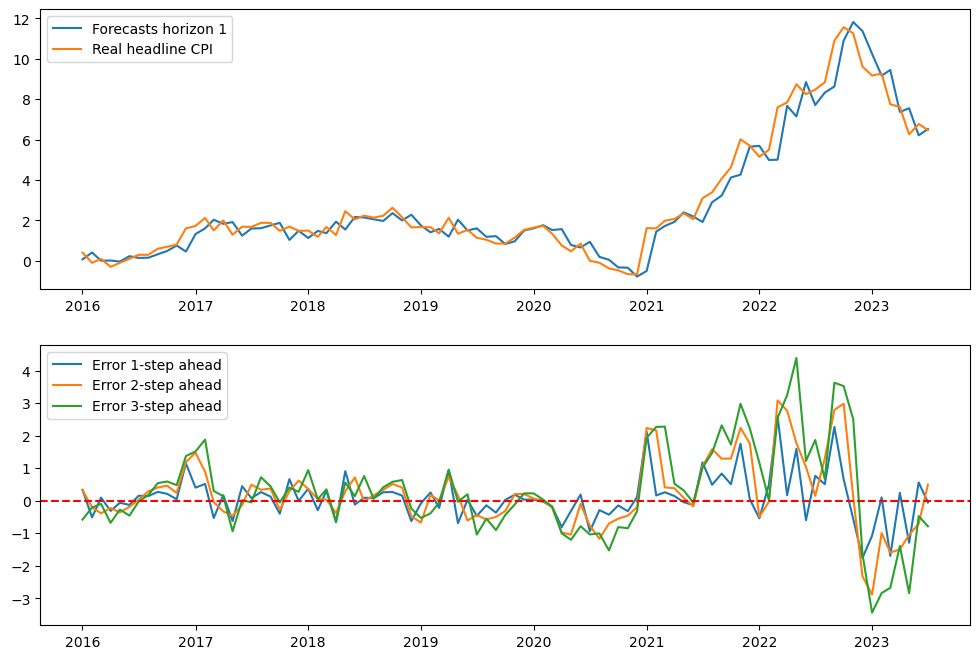

In [107]:
plt.figure(figsize = (12, 8))
plt.subplot(211)
plt.plot(forecast_df2.index, forecast_df2['Horizon_1'], label = 'Forecasts horizon 1')
plt.plot(forecast_df2['Real_obs'], label = 'Real headline CPI')
plt.legend()

plt.subplot(212)
plt.plot(forecast_df2['Error_horizon_1'], label = 'Error 1-step ahead')
plt.plot(forecast_df2['Error_horizon_2'], label = 'Error 2-step ahead')
plt.plot(forecast_df2['Error_horizon_3'], label = 'Error 3-step ahead')

plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.legend()
plt.show()


We can see the horizon 1 is the delayed results of CPI

test 1: 1/2016 - 12/2019 - precovid
test 2: 2020-2021 - during covid
test 3: 2022 - after covid and war and energy spike

In [108]:
for h in horizons:
    metrics_df.loc[h, 'base2_rmse'] = np.sqrt(mean_squared_error(forecast_df2['Real_obs'], forecast_df2[f'Horizon_{h}']))
    metrics_df.loc[h, 'base2_mae'] = mean_absolute_error(forecast_df2['Real_obs'], forecast_df2[f'Horizon_{h}'])

print(metrics_df)

  base1_rmse base1_mae  base2_rmse  base2_mae
1   0.643753  0.448755    0.715617   0.486189
2   0.926208   0.65364    1.061052   0.740414
3   1.204485  0.894005    1.418840   1.010374


In [75]:
# Cut into test set and calculate the avg of error during different periods: -> have to do it, but have to split the period before doing rmse
pre_covid = '2019-12-31'
end_covid = '2021-12-31'

# Define custom date ranges
custom_date_ranges = [
    ('01-01-2016 to 31-12-2019', forecast_df.index < pre_covid),
    ('01-01-2020 to 31-12-2021', (forecast_df.index >= pre_covid) & (forecast_df.index < end_covid)),
    ('01-01-2022 to 2023', forecast_df.index >= end_covid)
]

# Add a new column for custom date ranges
forecast_df['Date Range'] = pd.Categorical([label for label, condition in custom_date_ranges for _ in condition if _])
pivot_table = forecast_df.pivot_table(index='Date Range', values=['Error_horizon_1',
       'Error_horizon_2', 'Error_horizon_3'], aggfunc='mean')
pivot_table


,Error_horizon_1,Error_horizon_2,Error_horizon_3
Date Range,,,
01-01-2016 to 31-12-2019,0.056658,0.108098,0.133616
01-01-2020 to 31-12-2021,0.174661,0.342582,0.438886
01-01-2022 to 2023,0.125483,0.258285,0.456444
